<a href="https://colab.research.google.com/github/barslmn/XhetRel/blob/main/XHetRel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook can be used to detect relatedness between individuals and predict their sex by checking the X heterozygosity. This script has been designed to be used with exome sequencing VCF files from the same capture kit.

The pipeline compares multiple VCF files on relatedness therefore it requires at least **two** different samples' VCF files.

Pipeline filters out [pseudo autosomal regions](https://en.wikipedia.org/wiki/Pseudoautosomal_region) (PAR) using the coordinates: chrX:2781479-153925834 which works for both genome assemblies GRCh37/GRCh38. However, uploaded VCFs should belong to a single genome assembly only. Do not mix match genome versions.

Any output produced by this pipeline is for research use only.

You can leave feedback using [this form](https://forms.gle/XuqWcRskmtvRgnSc8).

---

## Usage Instructions

There are two main ways to use this notebook: you can run the provided demo data to test the pipeline, or you can use your own VCF files from Google Drive or by uploading them directly.

### Option 1: Run the Demo Data

This is the easiest way to see the pipeline in action.

1.  Run the **Demo Data** cell. It will download a small test dataset.
2.  Run the **XhetRel Analysis** cell.
3.  Follow the button prompts: **Check for VCF Files**, **Run Analysis**, and finally **Show/Download Report**.

---

### Option 2: Use Your Own Data

This workflow is managed entirely by the interactive control panel.

1.  Run the **XhetRel Analysis** cell. The full interface will appear.
2.  Connect to your data source:
    * **If your files are on Google Drive:** Click the **1. Mount Google Drive** button and grant the necessary permissions.
    * **If you are uploading files:** Use the file browser on the left-hand Colab sidebar to upload your VCF files into it.
3.  Select your directory: Use the file browser under **2. Select VCF Directory** to navigate to and select the folder containing your VCF files.
4.  Check for files: Click the **3. Check for VCF Files** button. A green success message will appear if your files are found.
5.  Run the analysis: Click the **4. Run Analysis** button. You can monitor the live progress in the output box below the button.
6.  View results: Once the analysis is complete, click **5a. Show Report** to view the results directly in the notebook or **5b. Download Report** to save the HTML file to your computer.

---

### Executing the blocks
Execute the blocks by pressing the "play" buttons next to them.

# Dependencies

Dependencies are installed automatically when the analysis is started.

| program  | version   | function                 |
| :------- | :-------- | :----------------------- |
| nextflow | v24.10.8  | Running the pipeline     |
| bcftools | v1.20     | Merging the VCF files    |
| vcftools | v0.1.16-3 | Relatedness 2 module     |
| multiqc  | v1.23     | Visualization            |

---


# Analysis pipeline schema

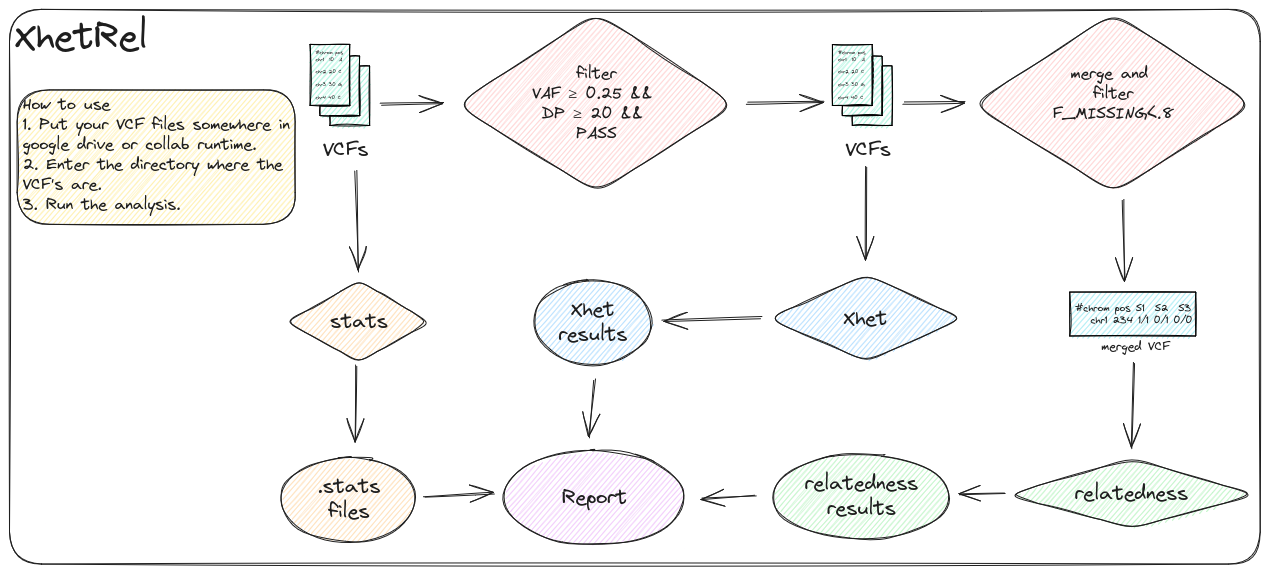

In [ ]:
#@title Video tutorials
import ipywidgets as widgets
from IPython.display import display, YouTubeVideo

# 1. Create your individual video objects (this part is the same)
video1 = YouTubeVideo('ZZSvtKn5SrE', width=800, height=450)
video2 = YouTubeVideo('ui1rYdNm2gY', width=800, height=450)
video3 = YouTubeVideo('L-AO1pBbjSM', width=800, height=450)

# 2. Create an Output widget for each video
# Think of this as a blank canvas for each tab
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()

# 3. "Display" each video *inside* its respective Output widget
with out1:
    display(video1)
with out2:
    display(video2)
with out3:
    display(video3)

# 4. Create the Tab widget using the Output widgets as children
tab_contents = [out1, out2, out3]
tab = widgets.Tab(children=tab_contents)

# 5. Set the title for each tab (this part is the same)
tab.set_title(0, 'Demo data')
tab.set_title(1, 'Uploading VCF files')
tab.set_title(2, 'Google drive')

# 6. Display the final tabbed widget
display(tab)

In [ ]:
#@title XhetRel Analysis Control Panel
!rm -rf /content/sample_data
# Step 1: Import all necessary libraries
import os
import subprocess
import ipywidgets as widgets
from google.colab import drive, files
from IPython.display import display, HTML, clear_output
from ipyfilechooser import FileChooser

# --- Define the content for the two Bash scripts ---

# Script 1: Handles all installations silently
install_script_content = """#!/bin/bash
set -e
install_bcftools() {
    if [ ! -f "/usr/local/bin/bcftools" ]; then
        apt-get update -qq && apt-get install -y -qq libgsl27
        wget -q http://barissalman.com/public/xhetrel/bcftools-ubuntu22-precompiled.tar.gz -O /tmp/bcftools.tar.gz
        tar -xzf /tmp/bcftools.tar.gz -C /usr/local/
        ln -sf /usr/local/bcftools/bin/bcftools /usr/local/bin/bcftools
        rm /tmp/bcftools.tar.gz
    fi
}
install_tools() {
    install_bcftools
    pip install -q git+https://github.com/MultiQC/MultiQC
    apt-get update -y -qq && apt-get install -y -qq vcftools
    curl -sL -o nextflow-24.10.8-dist https://github.com/nextflow-io/nextflow/releases/download/v24.10.8/nextflow-24.10.8-dist && chmod +x nextflow-24.10.8-dist
}
check_tools() {
    if ! command -v vcftools &> /dev/null || ! command -v bcftools &> /dev/null || ! command -v multiqc &> /dev/null || [ ! -f "./nextflow-24.10.8-dist" ]; then
        install_tools
    fi
}
check_tools
"""

# Script 2: Runs the actual analysis
run_script_content = """#!/bin/bash
set -e
vcf_dir=$1
if [ -z "$vcf_dir" ]; then
    echo "Error: No input directory provided."
    exit 1
fi
echo "✅ VCF Directory: $vcf_dir"
run_analysis() {
    echo "🚀 Starting analysis..."
    NXF_ANSI_LOG=false ./nextflow-24.10.8-dist XhetRel/main.nf --input_dir "$vcf_dir" --output_dir "/content"
    echo "✅ Analysis complete! Report generated."
}
start=$(date +%s)
run_analysis
end=$(date +%s)
runtime=$((end-start))
echo "⏱️ Total runtime: $runtime seconds."
"""

# --- Global state variables ---
vcf_dir = ""
vcfs_exists = False
report_is_visible = False
# New global variable to hold checkbox widgets for the cleanup tool
file_checkboxes = {}


# --- Helper Functions ---
def print_card(message, color="grey"):
    """Displays a message inside an attention-grabbing card."""
    icon_map = {"green": "✅", "red": "❌", "orange": "⚠️"}
    icon = icon_map.get(color, "ℹ️")
    border_color = color if color in icon_map else "#606770"
    card_html = f"""
    <div style="border-left: 5px solid {border_color}; background-color: #f1f1f1;
        border-radius: 5px; padding: 16px; margin: 10px 0;
        box-shadow: 2px 2px 5px rgba(0,0,0,0.1); font-family: sans-serif;">
        <h3 style="margin:0; padding:0; color: #1c1e21; font-size: 1.1em;">
            <span style="font-size: 1.3em; vertical-align: middle;">{icon}</span> {message}
        </h3>
    </div>"""
    display(HTML(card_html))

def run_shell_command(command, output_widget):
    """Runs a shell command and streams its output to a widget."""
    with output_widget:
        try:
            process = subprocess.Popen(
                command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                text=True, bufsize=1, universal_newlines=True
            )
            for line in process.stdout:
                print(line, end='')
            process.wait()
            if process.returncode != 0:
                print_card(f"Error executing command. Return code: {process.returncode}", color="red")
                return False
        except Exception as e:
            print_card(f"An exception occurred: {e}", color="red")
            return False
    return True

# --- Define Widgets ---
mount_button = widgets.Button(description="1a. Mount Google Drive", icon='google-drive', button_style='primary', layout=widgets.Layout(width='33%'))
upload_button = widgets.Button(description="1b. Upload from Computer", icon='upload', button_style='primary', layout=widgets.Layout(width='33%'))
demo_button = widgets.Button(description="1c. Download Demo Data", icon='cloud-download', button_style='info', layout=widgets.Layout(width='33%'))

file_chooser = FileChooser('/content/', title='<b>2. Select VCF Directory (If google drive is mounted)</b>', show_hidden=False, show_only_dirs=True, select_default=True)
check_button = widgets.Button(description="3. Check for VCF Files", icon='search', button_style='info', layout=widgets.Layout(width='49%'))
cleanup_button = widgets.Button(description="Clean Up Uploaded Files", icon='trash', button_style='danger', layout=widgets.Layout(width='49%')) # New Button
run_button = widgets.Button(description="4. Run Analysis", icon='cogs', button_style='success', disabled=True, layout=widgets.Layout(width='98%'))
report_button = widgets.Button(description="5a. Show Report", icon='file-html-o', button_style='warning', disabled=True,
                               layout=widgets.Layout(width='49%'))
download_button = widgets.Button(description="5b. Download Report", icon='download', button_style='info', disabled=True,
                                 layout=widgets.Layout(width='49%'))

mount_output = widgets.Output()
demo_output = widgets.Output()
upload_output = widgets.Output()
check_output = widgets.Output()
cleanup_output = widgets.Output() # New Output
run_output = widgets.Output()
report_output = widgets.Output()
download_output = widgets.Output()

# --- Define Widget Actions ---
def clear_setup_outputs():
    """Clears all output widgets from the first row of buttons."""
    mount_output.clear_output()
    demo_output.clear_output()
    upload_output.clear_output()

def mount_drive_action(b):
    clear_setup_outputs()
    with mount_output:
        try:
            drive.mount('/content/drive', force_remount=True)
            file_chooser.reset('/content/drive/MyDrive')
            print_card("Google Drive mounted successfully.", color="green")
        except Exception as e:
            print_card(f"An error occurred during mounting: {e}", color="red")

def download_demo_action(b):
    clear_setup_outputs()
    demo_commands = """
    echo "Downloading test VCF files..."
    wget -q http://barissalman.com/public/xhetrel/xhetrel_test_vcfs.zip -O /content/xhetrel_test_vcfs.zip
    unzip -oq /content/xhetrel_test_vcfs.zip -d /content/demo_vcfs/
    rm /content/xhetrel_test_vcfs.zip
    echo "✅ Test data is ready in /content/"
    """
    with demo_output:
        process = subprocess.Popen('/bin/bash', stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        stdout, _ = process.communicate(demo_commands)
        print(stdout)
        if process.returncode == 0:
            print_card("Demo data downloaded successfully.", "green")
            file_chooser.reset('/content/demo_vcfs')
        else:
            print_card("Failed to download demo data.", "red")

def upload_files_action(b):
    """Handles uploading files from the user's computer and validates file types."""
    clear_setup_outputs()
    upload_dir = "/content/user_vcfs"
    os.makedirs(upload_dir, exist_ok=True)

    with upload_output:
        clear_output()
        print_card("Please select VCF files (.vcf, .vcf.gz) to upload.", "grey")
        try:
            # `files.upload()` returns a dictionary of {filename: content}
            # and saves a temporary copy to /content
            uploaded = files.upload()

            # Handle case where user cancels the upload dialog
            if not uploaded:
                clear_output()
                print_card("Upload cancelled or no files were selected.", "orange")
                return

            accepted_files = []
            rejected_files = []

            for filename, content in uploaded.items():
                # Check for valid file extensions
                if filename.endswith(('.vcf', '.vcf.gz')):
                    # Write the file content to the target directory
                    with open(os.path.join(upload_dir, filename), 'wb') as f:
                        f.write(content)
                    accepted_files.append(filename)

                    # --- NEW FIX ---
                    # Immediately remove the temporary file from /content to
                    # prevent renaming on subsequent uploads of the same file.
                    try:
                        os.remove(os.path.join('/content', filename))
                    except OSError:
                        # This might fail if the file isn't where we expect,
                        # but we can safely ignore it and continue.
                        pass
                    # --- END FIX ---

                else:
                    rejected_files.append(filename)

            # Clear the "Please select files" message before showing results
            clear_output()

            # Report results to the user
            if accepted_files:
                print_card(f"Successfully uploaded {len(accepted_files)} valid VCF file(s).", "green")
                # Update the file chooser to point to the upload directory
                file_chooser.reset(upload_dir)
            elif rejected_files:
                # This case handles when the user uploaded files, but NONE of them were valid
                print_card("No valid VCF files were uploaded.", "red")

            if rejected_files:
                rejected_list = ", ".join(rejected_files)
                print_card(f"Ignored {len(rejected_files)} file(s) with invalid extensions: {rejected_list}", "orange")

        except Exception as e:
            clear_output()
            print_card(f"An error occurred during upload: {e}", "red")

def check_files_action(b):
    global vcf_dir, vcfs_exists, report_is_visible
    vcf_dir = file_chooser.selected
    run_button.disabled = True
    report_button.disabled = True
    download_button.disabled = True
    report_is_visible = False
    with report_output: clear_output()
    with download_output: clear_output()

    with check_output:
        clear_output()
        if not vcf_dir or not os.path.isdir(vcf_dir):
            print_card("Please select a valid directory first.", color="orange")
            vcfs_exists = False
            return

        list_vcfs_cmd = f'find "{vcf_dir}" -maxdepth 1 -type f \\( -name "*.vcf" -o -name "*.vcf.gz" \\)'
        found_files = !{list_vcfs_cmd}
        num_files = len(found_files)

        if num_files > 1:
            vcfs_exists = True
            print_card(f"{num_files} VCF files found! You can now run the analysis. ✅", color="green")
            file_list_items = "<br>".join([f"&nbsp;&nbsp;•&nbsp;{os.path.basename(f)}" for f in found_files])
            collapsible_html = f"""
            <details style="margin-top: 10px;">
                <summary style="cursor: pointer; font-weight: bold; color: #333; margin-left: 5px;">
                    Click to view the {num_files} file(s)
                </summary>
                <div style="max-height: 200px; overflow-y: auto; border: 1px solid #ddd; padding: 10px; margin-top: 5px; background-color: #fdfdfd; font-family: monospace; line-height: 1.6; border-radius: 4px;">
                    {file_list_items}
                </div>
            </details>"""
            display(HTML(collapsible_html))
            run_button.disabled = False
        elif num_files == 1:
            vcfs_exists = False
            print_card("Only 1 VCF file was found. This analysis requires at least two VCF files. ⚠️", color="orange")
        else:
            vcfs_exists = False
            print_card("No VCF files (.vcf, .vcf.gz) found in the selected directory. ❌", color="red")

def cleanup_files_action(b):
    """Displays UI for selecting and deleting uploaded VCF files."""
    global file_checkboxes
    upload_dir = "/content/user_vcfs"

    with cleanup_output:
        clear_output()

        if not os.path.isdir(upload_dir):
            print_card("Upload directory not found. Please upload files first.", "orange")
            return

        vcf_files = [f for f in os.listdir(upload_dir) if f.endswith(('.vcf', '.vcf.gz'))]

        if not vcf_files:
            print_card("No uploaded VCF files to clean up.", "green")
            return

        # --- Create widgets for the cleanup UI ---
        file_checkboxes.clear()
        checkbox_widgets = []
        for filename in sorted(vcf_files):
            cb = widgets.Checkbox(value=False, description=filename, indent=False)
            file_checkboxes[filename] = cb
            checkbox_widgets.append(cb)

        check_all_box = widgets.Checkbox(value=False, description='Select All', indent=False)
        delete_button = widgets.Button(description="Delete Selected Files", button_style='danger', icon='trash', disabled=True)

        # --- Define actions for the new widgets ---
        def on_check_all_change(change):
            for cb in file_checkboxes.values():
                cb.value = change.new

        def on_checkbox_change(change):
            any_checked = any(cb.value for cb in file_checkboxes.values())
            delete_button.disabled = not any_checked

        def on_delete_click(db):
            # THIS IS THE CRITICAL FIX: Wrap the entire function's logic
            # in the output widget's context.
            with cleanup_output:
                files_to_delete = [fname for fname, cb in file_checkboxes.items() if cb.value]
                if not files_to_delete:
                    return

                deleted_count = 0
                for filename in files_to_delete:
                    try:
                        os.remove(os.path.join(upload_dir, filename))
                        deleted_count += 1
                    except Exception as e:
                        # This will now correctly print inside the widget
                        print(f"Error deleting {filename}: {e}")

                # This call will now only clear the cleanup_output widget
                clear_output()
                print_card(f"Successfully removed {deleted_count} file(s).", "green")

                # Recursively call to refresh the file list within the same widget
                cleanup_files_action(None)

        # --- Link actions to the new widgets ---
        check_all_box.observe(on_check_all_change, names='value')
        for cb in file_checkboxes.values():
            cb.observe(on_checkbox_change, names='value')
        delete_button.on_click(on_delete_click)

        # --- Display the new UI ---
        cleanup_ui = widgets.VBox([
            widgets.HTML("<b>Select files to remove from the <code>/content/user_vcfs/</code> directory:</b>"),
            check_all_box,
            widgets.VBox(checkbox_widgets, layout=widgets.Layout(max_height='200px', overflow_y='auto', border='1px solid #ddd', padding='5px')),
            delete_button
        ])
        display(cleanup_ui)


def run_analysis_action(b):
    global report_is_visible
    b.disabled = True
    b.icon = 'spinner'
    report_button.disabled = True
    download_button.disabled = True
    report_is_visible = False
    report_button.description = "5a. Show Report"

    try:
        with run_output:
            clear_output()
            print_card("Starting the analysis workflow...", color="grey")

            if not os.path.isdir("XhetRel"):
                 print("Cloning repository...")
                 clone_success = run_shell_command(['git', 'clone', '-q', 'https://github.com/barslmn/XhetRel'], run_output)
                 if not clone_success: return

            install_script_path = "XhetRel/install_dependencies.sh"
            run_script_path = "XhetRel/run_analysis.sh"
            try:
                with open(install_script_path, "w") as f: f.write(install_script_content)
                with open(run_script_path, "w") as f: f.write(run_script_content)
                subprocess.run(['chmod', '+x', install_script_path], check=True)
                subprocess.run(['chmod', '+x', run_script_path], check=True)
            except Exception as e:
                print_card(f"Error writing script files: {e}", "red"); return

            b.description = "Installing Dependencies..."
            install_process = subprocess.run([install_script_path], capture_output=True)
            if install_process.returncode != 0:
                print_card("Error during dependency installation.", "red")
                print(install_process.stderr.decode())
                return
            print_card("Dependencies are ready.", "green")

            b.description = "Running Analysis..."
            analysis_success = run_shell_command([run_script_path, vcf_dir], run_output)
            if analysis_success:
                report_button.disabled = False
                download_button.disabled = False
    finally:
        b.description = "4. Run Analysis"
        b.icon = 'cogs'

def show_report_action(b):
    global report_is_visible
    with report_output:
        if report_is_visible:
            clear_output()
            report_is_visible = False
            b.description = "5a. Show Report"
        else:
            clear_output()
            report_path = '/content/XhetRel_flat_multiqc_report.html'
            if os.path.exists(report_path):
                print_card("Displaying MultiQC Report:", color="green")
                display(HTML(filename=report_path))
                report_is_visible = True
                b.description = "5a. Close Report"
            else:
                print_card("Report file not found. Please run the analysis first.", color="red")
                report_is_visible = False

def download_report_action(b):
    with download_output:
        clear_output()
        report_path = '/content/XhetRel_interactive_multiqc_report.html'
        try:
            if os.path.exists(report_path):
                print_card("Preparing download...", color="grey")
                files.download(report_path)
                clear_output()
                print_card("Download completed successfully!", color="green")
            else:
                print_card("Interactive report file not found. Please run the analysis first.", color="red")
        except Exception as e:
            print_card(f"An error occurred during download: {e}", color="red")

# --- Link Actions to Buttons ---
mount_button.on_click(mount_drive_action)
demo_button.on_click(download_demo_action)
upload_button.on_click(upload_files_action)
check_button.on_click(check_files_action)
cleanup_button.on_click(cleanup_files_action) # New Link
run_button.on_click(run_analysis_action)
report_button.on_click(show_report_action)
download_button.on_click(download_report_action)

# --- Assemble and Display UI ---
setup_buttons = widgets.HBox([mount_button, upload_button, demo_button])
check_buttons = widgets.HBox([check_button, cleanup_button]) # New HBox
report_buttons = widgets.HBox([report_button, download_button])

ui = widgets.VBox([
    setup_buttons,
    mount_output, demo_output, upload_output,
    widgets.HTML("<hr>"),
    file_chooser,
    check_buttons, # Updated line
    check_output,
    cleanup_output, # New output widget display
    widgets.HTML("<hr>"),
    run_button, run_output,
    widgets.HTML("<hr>"),
    report_buttons, report_output, download_output
])

display(ui)